In [7]:
import sys
import os
import mxnet as mx
import numpy as np
import pandas as pd
import data
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import model
from autoencoder import AutoEncoderModel
from solver import Solver, Monitor
import logging
import sklearn
from sklearn.manifold import TSNE
from utilities import *
try:
   import cPickle as pickle
except:
   import pickle
import gzip

# for visualization
from sklearn.manifold import TSNE
from utilities import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from itertools import cycle


## Gather RFE optimal subset and use only these features in the analysis

In [10]:

NME_nxgraphs = r'Z:\Cristina\Section3\paper_notes_section3_MODIFIED\datasets'
    
allNMEs_dynamic = pd.read_csv(os.path.join(NME_nxgraphs,'dyn_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_morphology = pd.read_csv(os.path.join(NME_nxgraphs,'morpho_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_texture = pd.read_csv(os.path.join(NME_nxgraphs,'text_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_stage1 = pd.read_csv(os.path.join(NME_nxgraphs,'stage1_roi_records_allNMEs_descStats.csv'), index_col=0)

# to load discrall_dict dict for all lesions
discrall_dict_allNMEs =   pd.read_csv(os.path.join(NME_nxgraphs, "named_nxGnormfeatures_allNMEs_descStats.csv"), index_col=0)

# to load SERw matrices for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGdatafeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    nxGdatafeatures = pickle.load(fin)        


In [11]:

NME_nxgraphs = r'Z:\Cristina\Section3\paper_notes_section3_MODIFIED\datasets'

optimalFeatureSet = pd.read_csv(os.path.join(NME_nxgraphs,'optimalFeatureSet.csv'), index_col=0)

# fnames, ftypes
ftype_dyn = optimalFeatureSet.loc[(optimalFeatureSet['ftypes'] == "dynamic")]
# select 9 columns
selNMEs_dynamic = allNMEs_dynamic[ftype_dyn['fnames']]  

ftype_morp = optimalFeatureSet.loc[(optimalFeatureSet['ftypes'] == "morphology")]
# select 8 columns
selNMEs_morphology = allNMEs_morphology[ftype_morp['fnames']]  

ftype_text = optimalFeatureSet.loc[(optimalFeatureSet['ftypes'] == "texture")]
# select 30 columns
selNMEs_texture = allNMEs_texture[ftype_text['fnames']]  

ftype_stage1 = optimalFeatureSet.loc[(optimalFeatureSet['ftypes'] == "stage1")]
# select 29 columns
selNMEs_stage1 = allNMEs_stage1[ftype_stage1['fnames']]  

ftype_nxG = optimalFeatureSet.loc[(optimalFeatureSet['ftypes'] == "NetworkConnectivity")]
# select 34 columns
seldiscrall_dict_allNMEs = discrall_dict_allNMEs[ftype_nxG['fnames']]  

#########  
nxGdiscfeatures = seldiscrall_dict_allNMEs   
print('Loading {} leasions with nxGdiscfeatures of size = {}'.format(nxGdiscfeatures.shape[0], nxGdiscfeatures.shape[1]) )

print('Normalizing dynamic {} leasions with features of size = {}'.format(selNMEs_dynamic.shape[0], selNMEs_dynamic.shape[1]))
normdynamic = (selNMEs_dynamic - selNMEs_dynamic.mean(axis=0)) / selNMEs_dynamic.std(axis=0)
normdynamic.mean(axis=0)

print('Normalizing morphology {} leasions with features of size = {}'.format(selNMEs_morphology.shape[0], allNMEs_morphology.shape[1]))
normorpho = (selNMEs_morphology - selNMEs_morphology.mean(axis=0)) / selNMEs_morphology.std(axis=0)
normorpho.mean(axis=0)

print('Normalizing texture {} leasions with features of size = {}'.format(selNMEs_texture.shape[0], selNMEs_texture.shape[1]))
normtext = (allNMEs_texture - allNMEs_texture.mean(axis=0)) / selNMEs_texture.std(axis=0)
normtext.mean(axis=0)

print('Normalizing stage1 {} leasions with features of size = {}'.format(allNMEs_stage1.shape[0], allNMEs_stage1.shape[1]))
normstage1 = (selNMEs_texture - selNMEs_texture.mean(axis=0)) / allNMEs_stage1.std(axis=0)
normstage1.mean(axis=0)

# shape input (798L, 427L)    
combX_allNME = np.concatenate((nxGdiscfeatures, normdynamic.as_matrix(), normorpho.as_matrix(), normtext.as_matrix(), normstage1.as_matrix()), axis=1)       
YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} Optimal Subset of NME features of size = {}'.format(combX_allNME.shape[0], combX_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0])   )

#########
# define variables for classifier
roi_labels = YnxG_allNME[1]  
roi_labels = ['K' if rl=='U' else rl for rl in roi_labels]

## use y_dec to  minimizing KL divergence for clustering with known classes
ysup = ["{}_{}_{}".format(a, b, c) if b!='nan' else "{}_{}".format(a, c) for a, b, c in zip(YnxG_allNME[1], YnxG_allNME[2], YnxG_allNME[3])]
ysup = ['K'+rl[1::] if rl[0]=='U' else rl for rl in ysup]
classes = [str(c) for c in np.unique(ysup)]
numclasses = [i for i in range(len(classes))]
y_dec = []
for k in range(len(ysup)):
    for j in range(len(classes)):
        if(str(ysup[k])==classes[j]): 
            y_dec.append(numclasses[j])
y_dec = np.asarray(y_dec)
combX_allNME[np.isnan(combX_allNME)] = 0.00001

Loading 792 leasions with nxGdiscfeatures of size = 34
Normalizing dynamic 792 leasions with features of size = 9
Normalizing morphology 792 leasions with features of size = 19
Normalizing texture 792 leasions with features of size = 30
Normalizing stage1 792 leasions with features of size = 100
Loading 792 Optimal Subset of NME features of size = 225
Loading all NME lables [label,BIRADS,dist,enh] of size = 792


## MLP as classifier (experiment modified #1 or Baseline)


In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy import interp
from itertools import cycle

# unbiased validation with held-out set
sep = int(combX_allNME.shape[0]*0.10)
X_val = combX_allNME[:sep]
y_val = roi_labels[:sep]
y_val = (np.asarray(y_val)=='M').astype(int)

X_train = combX_allNME[sep:]
y_train = roi_labels[sep:]

# Classification and ROC analysis
datalabels = np.asarray(y_train)
dataspace = X_train
# ignore unlabeled cases, supervised learning only relies on labels
X = dataspace[datalabels!='K',:]
y = np.asarray(datalabels[datalabels!='K']=='M').astype(int)

#####################
# MLP fully coneected networks for classification
#####################
batch_size = 50
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, random_state=33)
# Evaluate a score by cross-validation           
tprs_train_baseL = []; auc_train_baseL = []
tprs_val_baseL = []; auc_val_baseL = []
mean_fpr_OrigX = np.linspace(0, 1, 100)
cvi = 0
for train, test in cv.split(X, y):
    # Multilayer Perceptron
    MLP_train_iter = mx.io.NDArrayIter(X[train], y[train], batch_size, shuffle=False)
    MLP_val_iter = mx.io.NDArrayIter(X[test], y[test], batch_size)    
    
    # We’ll define the MLP using MXNet’s symbolic interface
    dataMLP = mx.sym.Variable('data')
    
    #The following code declares two fully connected layers with 128 and 64 neurons each. 
    #Furthermore, these FC layers are sandwiched between ReLU activation layers each 
    #one responsible for performing an element-wise ReLU transformation on the FC layer output.
    # The first fully-connected layer and the corresponding activation function
    fc1  = mx.sym.FullyConnected(data=dataMLP, num_hidden = 128)
    act1 = mx.sym.Activation(data=fc1, act_type="relu")
    
    fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 32)
    act2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    # data has 2 classes
    fc3  = mx.sym.FullyConnected(data=act2, num_hidden=2)
    # Softmax with cross entropy loss
    mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')
    
    # create a trainable module on CPU                   
    mon = mx.mon.Monitor(interval=100, pattern='.*', sort=True); # Defaults to mean absolute value |x|/size(x)
    #checkpoint = mx.callback.do_checkpoint('mlp_model_params_z{}_mu{}.arg'.format(self.best_args['znum'],self.best_args['num_centers']))
    mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())
    mlp_model.fit(MLP_train_iter,  # train data
                  optimizer='sgd',  # use SGD to train
                  optimizer_params={'learning_rate':0.01},  # use fixed learning rate
                  eval_metric= 'acc', #MLPacc(yZ_val, Z_val),  # report accuracy during trainin
                  monitor=mon,
                  num_epoch=850)
                  
                  #epoch_end_callbackcheckpoint)  # train for at most 10 dataset passes. extras:               #monitor=mon,
    ## predict on training set too
    prob_train = mlp_model.predict(MLP_train_iter)        
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[train], prob_train.asnumpy()[:,1])
    # to create an ROC with 100 pts
    tprs_train_baseL.append(interp(mean_fpr_OrigX, fpr, tpr))
    tprs_train_baseL[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    print "train cv", cvi, roc_auc
    auc_train_baseL.append(roc_auc)
    
    #After the above training completes, we can evaluate the trained model by running predictions on validation data. 
    #The following source code computes the prediction probability scores for each validation data. 
    # prob[i][j] is the probability that the i-th validation contains the j-th output class.
    prob_val = mlp_model.predict(MLP_val_iter)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], prob_val.asnumpy()[:,1])
    # to create an ROC with 100 pts
    tprs_val_baseL.append(interp(mean_fpr_OrigX, fpr, tpr))
    tprs_val_baseL[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    print "val cv", cvi, roc_auc
    auc_val_baseL.append(roc_auc)
    cvi += 1

################
MLP_heldout_iter = mx.io.NDArrayIter(X_val, None, batch_size)   
probas_heldout_baseL = mlp_model.predict(MLP_heldout_iter)
   

train cv 0 0.697028540462
val cv 0 0.758021390374
train cv 1 0.675767007559
val cv 1 0.791193181818
train cv 2 0.714146772767
val cv 2 0.635174418605
train cv 3 0.713704686118
val cv 3 0.646802325581
train cv 4 0.739434129089
val cv 4 0.556686046512


## Load datasets for proposed framework

In [16]:
#########
# to load discrall_dict dict for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGnormfeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    discrall_dict_allNMEs = pickle.load(fin)   
    
# shape input (798L, 427L)     
nxGdiscfeatures = discrall_dict_allNMEs   
print('Loading {} leasions with nxGdiscfeatures of size = {}'.format(nxGdiscfeatures.shape[0], nxGdiscfeatures.shape[1]) )

print('Normalizing dynamic {} leasions with features of size = {}'.format(allNMEs_dynamic.shape[0], allNMEs_dynamic.shape[1]))
normdynamic = (allNMEs_dynamic - allNMEs_dynamic.mean(axis=0)) / allNMEs_dynamic.std(axis=0)
normdynamic.mean(axis=0)

print('Normalizing morphology {} leasions with features of size = {}'.format(allNMEs_morphology.shape[0], allNMEs_morphology.shape[1]))
normorpho = (allNMEs_morphology - allNMEs_morphology.mean(axis=0)) / allNMEs_morphology.std(axis=0)
normorpho.mean(axis=0)

print('Normalizing texture {} leasions with features of size = {}'.format(allNMEs_texture.shape[0], allNMEs_texture.shape[1]))
normtext = (allNMEs_texture - allNMEs_texture.mean(axis=0)) / allNMEs_texture.std(axis=0)
normtext.mean(axis=0)

print('Normalizing stage1 {} leasions with features of size = {}'.format(allNMEs_stage1.shape[0], allNMEs_stage1.shape[1]))
normstage1 = (allNMEs_stage1 - allNMEs_stage1.mean(axis=0)) / allNMEs_stage1.std(axis=0)
normstage1.mean(axis=0)

# shape input (798L, 427L)    
combX_allNME = np.concatenate((nxGdiscfeatures, normdynamic.as_matrix(), normorpho.as_matrix(), normtext.as_matrix(), normstage1.as_matrix()), axis=1)       
YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} all NME of size = {}'.format(combX_allNME.shape[0], combX_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0])   )

# define variables for DEC 
roi_labels = YnxG_allNME[1]  
roi_labels = ['K' if rl=='U' else rl for rl in roi_labels]

## use y_dec to  minimizing KL divergence for clustering with known classes
ysup = ["{}_{}_{}".format(a, b, c) if b!='nan' else "{}_{}".format(a, c) for a, b, c in zip(YnxG_allNME[1], YnxG_allNME[2], YnxG_allNME[3])]
ysup = ['K'+rl[1::] if rl[0]=='U' else rl for rl in ysup]
classes = [str(c) for c in np.unique(ysup)]
numclasses = [i for i in range(len(classes))]
y_dec = []
for k in range(len(ysup)):
    for j in range(len(classes)):
        if(str(ysup[k])==classes[j]): 
            y_dec.append(numclasses[j])
y_dec = np.asarray(y_dec)
combX_allNME[np.isnan(combX_allNME)] = 0.00001

Loading 792 leasions with nxGdiscfeatures of size = 326
Normalizing dynamic 792 leasions with features of size = 34
Normalizing morphology 792 leasions with features of size = 19
Normalizing texture 792 leasions with features of size = 44
Normalizing stage1 792 leasions with features of size = 100
Loading 792 all NME of size = 523
Loading all NME lables [label,BIRADS,dist,enh] of size = 792


## Gather results of Step 1 (after SAE dimensionality reduction)

In [17]:
## From Pre-train/fine tune the SAE
######################
from decModel_wimgF_dualopt_descStats import *
from utilities import *
import model

save_to = r'Z:\Cristina\Section3\paper_notes_section3_MODIFIED\save_to\SAEmodels'
input_size = combX_allNME.shape[1]
latent_size = [input_size/rxf for rxf in [15,10,5,2]]

############ BEST PERFORMIGN of Step 1 nzum = 2x
znum=261
    
X = combX_allNME
y = roi_labels
xpu = mx.cpu()
ae_model = AutoEncoderModel(xpu, [X.shape[1],500,500,2000,znum], pt_dropout=0.2)
print('Loading autoencoder of znum = {}, post training'.format(znum))
ae_model.load( os.path.join(save_to,'SAE_zsize{}_wimgfeatures_descStats_zeromean.arg'.format(str(znum))) ) 

data_iter = mx.io.NDArrayIter({'data': X}, 
                              batch_size=X.shape[0], shuffle=False,
                              last_batch_handle='pad')
# extract only the encoder part of the SAE                              
feature = ae_model.encoder
zspace = model.extract_feature(feature, ae_model.args, None, data_iter, X.shape[0], xpu).values()[0]   
    
# pool Z-space variables
datalabels = np.asarray(y)
dataZspace = zspace
    
#####################
# unbiased assessment: SPlit train/held-out test
#####################
# to compare performance need to discard unkown labels, only use known labels (only B or M)
Z = dataZspace[datalabels!='K',:]
y = datalabels[datalabels!='K']
  
print '\n... MLP fully coneected layer trained on Z_train tested on Z_test' 
sep = int(X.shape[0]*0.10)
Z_test = Z[:sep]
yZ_test = np.asanyarray(y[:sep]=='M').astype(int) 
Z_train = Z[sep:]
yZ_train = np.asanyarray(y[sep:]=='M').astype(int) 
    
#####################
# Z-space MLP fully coneected layer for classification
#####################
batch_size = 50
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, random_state=33)
# Evaluate a score by cross-validation           
tprs_train_step1 = []; aucs_train_step1 = []
tprs_val_step1 = []; aucs_val_step1 = []
mean_fpr_step1 = np.linspace(0, 1, 100)    
cvi = 0
for train, test in cv.split(Z_train, yZ_train):
    # Multilayer Perceptron
    MLP_train_iter = mx.io.NDArrayIter(Z_train[train], yZ_train[train], batch_size, shuffle=False)
    MLP_val_iter = mx.io.NDArrayIter(Z_train[test], yZ_train[test], batch_size)    

    # We’ll define the MLP using MXNet’s symbolic interface
    dataMLP = mx.sym.Variable('data')
    #The following code declares two fully connected layers with 128 and 64 neurons each. 
    #Furthermore, these FC layers are sandwiched between ReLU activation layers each 
    #one responsible for performing an element-wise ReLU transformation on the FC layer output.
    # The first fully-connected layer and the corresponding activation function
    fc1  = mx.sym.FullyConnected(data=dataMLP, num_hidden = 128)
    act1 = mx.sym.Activation(data=fc1, act_type="relu")
    fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 32)
    act2 = mx.sym.Activation(data=fc2, act_type="relu")
    # data has 2 classes
    fc3  = mx.sym.FullyConnected(data=act2, num_hidden=2)
    # Softmax with cross entropy loss
    mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')
    
    # create a trainable module on CPU                   
    mon = mx.mon.Monitor(interval=100, pattern='.*', sort=True); # Defaults to mean absolute value |x|/size(x)
    #checkpoint = mx.callback.do_checkpoint('mlp_model_params_z{}_mu{}.arg'.format(self.best_args['znum'],self.best_args['num_centers']))
    mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())
    mlp_model.fit(MLP_train_iter,  # train data
                  optimizer='sgd',  # use SGD to train
                  optimizer_params={'learning_rate':0.01},  # use fixed learning rate
                  eval_metric= 'acc', #MLPacc(yZ_val, Z_val),  # report accuracy during trainin
                  monitor=mon,
                  num_epoch=850)
                  #epoch_end_callbackcheckpoint)  # train for at most 10 dataset passes. extras:               #monitor=mon,

    ############### on train
    prob_train = mlp_model.predict(MLP_train_iter)
    # Compute ROC curve and area the curve
    fpr_train, tpr_train, thresholds_train = roc_curve(yZ_train[train], prob_train.asnumpy()[:,1])
    # to create an ROC with 100 pts
    tprs_train_step1.append(interp(mean_fpr_step1, fpr_train, tpr_train))
    tprs_train_step1[-1][0] = 0.0
    roc_auc = auc(fpr_train, tpr_train)
    aucs_train_step1.append(roc_auc)
    
    ############### on validation
    # prob[i][j] is the probability that the i-th validation contains the j-th output class.
    prob_val = mlp_model.predict(MLP_val_iter)
    # Compute ROC curve and area the curve
    fpr_val, tpr_val, thresholds_val = roc_curve(yZ_train[test], prob_val.asnumpy()[:,1])
    # to create an ROC with 100 pts
    tprs_val_step1.append(interp(mean_fpr_step1, fpr_val, tpr_val))
    tprs_val_step1[-1][0] = 0.0
    roc_auc = auc(fpr_val, tpr_val)
    aucs_val_step1.append(roc_auc)
    cvi += 1
    
MLP_heldout_iter = mx.io.NDArrayIter(Z_test, None, batch_size)   
probas_heldout_step1 = mlp_model.predict(MLP_heldout_iter)
  

Loading autoencoder of znum = 261, post training

... MLP fully coneected layer trained on Z_train tested on Z_test


## Gather results of Step 2 (after DEC embedding clustering)

In [18]:
labeltype = 'wimgF_dualopt_descStats_saveparams' 
save_to = r'Z:\Cristina\Section3\paper_notes_section3_MODIFIED\save_to'
num_centers = 3
X = combX_allNME
y = roi_labels
y_train_roi_labels = np.asarray(y)

print('Loading autoencoder of znum = {}, mu = {} , post training DEC results'.format(znum,num_centers))
dec_model = DECModel(mx.cpu(), X, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\paper_notes_section3_MODIFIED\\save_to\\SAEmodels') 

with gzip.open(os.path.join(save_to,'dec_model_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
    dec_model = pickle.load(fu)
  
with gzip.open(os.path.join(save_to,'outdict_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
    outdict = pickle.load(fu)

print('DEC train init AUC = {}'.format(outdict['meanAuc_cv'][0]))
max_meanAuc_cv = outdict['meanAuc_cv'][-1]
indmax_meanAuc_cv = outdict['meanAuc_cv'].index(max_meanAuc_cv)
print r'DEC train max meanAuc_cv = {} $\pm$ {}'.format(max_meanAuc_cv,dec_model['std_auc'][indmax_meanAuc_cv])
print('DEC validation AUC at max meanAuc_cv = {}'.format(outdict['auc_val'][indmax_meanAuc_cv]))


# extract Z-space from optimal DEC model
#####################
# saved output results
dec_args_keys = ['encoder_1_bias', 'encoder_3_weight', 'encoder_0_weight', 
'encoder_0_bias', 'encoder_2_weight', 'encoder_1_weight', 
'encoder_3_bias', 'encoder_2_bias']
dec_args = {key: v for key, v in dec_model.items() if key in dec_args_keys}
dec_args['dec_mubestacci'] = dec_model['dec_mu']

N = X.shape[0]
all_iter = mx.io.NDArrayIter({'data': X}, batch_size=X.shape[0], shuffle=False,
                                          last_batch_handle='pad')   
## extract embedded point zi 
mxdec_args = {key: mx.nd.array(v) for key, v in dec_args.items() if key != 'dec_mubestacci'}                           
aDEC = DECModel(mx.cpu(), X, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\paper_notes_section3_MODIFIED\\save_to\\SAEmodels') 

# organize weights and biases
l1=[v.asnumpy().shape for k,v in aDEC.ae_model.args.iteritems()]
k1=[k for k,v in aDEC.ae_model.args.iteritems()]
l2=[v.asnumpy().shape for k,v in mxdec_args.iteritems()]
k2=[k for k,v in mxdec_args.iteritems()]

for ikparam,sizeparam in enumerate(l1):
    for jkparam,savedparam in enumerate(l2):
        if(sizeparam == savedparam):
            #print('updating layer parameters: {}'.format(savedparam))
            aDEC.ae_model.args[k1[ikparam]] = mxdec_args[k2[jkparam]]

zbestacci = model.extract_feature(aDEC.feature, mxdec_args, None, all_iter, X.shape[0], aDEC.xpu).values()[0]      

# compute model-based best-pbestacci or dec_model['pbestacci']
pbestacci = np.zeros((zbestacci.shape[0], dec_model['num_centers']))
aDEC.dec_op.forward([zbestacci, dec_args['dec_mubestacci'].asnumpy()], [pbestacci])
#pbestacci = dec_model['pbestacci']

# pool Z-space variables
datalabels = np.asarray(y)
dataZspace = np.concatenate((zbestacci, pbestacci), axis=1) 

#####################
# unbiased assessment: SPlit train/held-out test
#####################
# to compare performance need to discard unkown labels, only use known labels (only B or M)
Z = dataZspace[datalabels!='K',:]
y = datalabels[datalabels!='K']
  
print '\n... MLP fully coneected layer trained on Z_train tested on Z_test' 
sep = int(X.shape[0]*0.10)
Z_test = Z[:sep]
yZ_test = np.asanyarray(y[:sep]=='M').astype(int) 
Z_train = Z[sep:]
yZ_train = np.asanyarray(y[sep:]=='M').astype(int) 
   
# We’ll load MLP using MXNet’s symbolic interface
dataMLP = mx.sym.Variable('data')
# MLP: two fully connected layers with 128 and 32 neurons each. 
fc1  = mx.sym.FullyConnected(data=dataMLP, num_hidden = 128)
act1 = mx.sym.Activation(data=fc1, act_type="relu")
fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 32)
act2 = mx.sym.Activation(data=fc2, act_type="relu")
# data has 2 classes
fc3  = mx.sym.FullyConnected(data=act2, num_hidden=2)
# Softmax output layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')
# create a trainable module on CPU     
batch_size = 50
mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())
# pass train/test data to allocate model (bind state)
MLP_train_iter = mx.io.NDArrayIter(Z_train, yZ_train, batch_size, shuffle=False)
mlp_model.bind(MLP_train_iter.provide_data, MLP_train_iter.provide_label)
mlp_model.init_params()   
mlp_model.init_optimizer()
mlp_model_params = mlp_model.get_params()[0]

# update parameters based on optimal found during cv Training
from mxnet import ndarray
params_dict = ndarray.load(os.path.join(save_to,'mlp_model_params_z{}_mu{}.arg'.format(znum,num_centers)))
arg_params = {}
aux_params = {}
for k, value in params_dict.items():
    arg_type, name = k.split(':', 1)
    if arg_type == 'arg':
        arg_params[name] = value
    elif arg_type == 'aux':
        aux_params[name] = value
    else:
        raise ValueError("Invalid param file ")

# order of params: [(128L, 266L),(128L,),(32L, 128L),(32L,),(2L, 32L),(2L,)]
# organize weights and biases
l1=[v.asnumpy().shape for k,v in mlp_model_params.iteritems()]
k1=[k for k,v in mlp_model_params.iteritems()]
l2=[v.asnumpy().shape for k,v in arg_params.iteritems()]
k2=[k for k,v in arg_params.iteritems()]

for ikparam,sizeparam in enumerate(l1):
    for jkparam,savedparam in enumerate(l2):
        if(sizeparam == savedparam):
            #print('updating layer parameters: {}'.format(savedparam))
            mlp_model_params[k1[ikparam]] = arg_params[k2[jkparam]]
# upddate model parameters
mlp_model.set_params(mlp_model_params, aux_params)

#####################
# ROC: Z-space MLP fully coneected layer for classification
#####################
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5,random_state=3)
# Evaluate a score by cross-validation
tprs_train_step2 = []; aucs_train_step2 = []
tprs_val_step2 = []; aucs_val_step2 = []
mean_fpr_step2 = np.linspace(0, 1, 100)
cvi = 0
for train, test in cv.split(Z_train, yZ_train):
    ############### on train
    MLP_train_iter = mx.io.NDArrayIter(Z_train[train], yZ_train[train], batch_size)  
    # prob[i][j] is the probability that the i-th validation contains the j-th output class.
    prob_train = mlp_model.predict(MLP_train_iter)
    # Compute ROC curve and area the curve
    fpr_train, tpr_train, thresholds_train = roc_curve(yZ_train[train], prob_train.asnumpy()[:,1])
    # to create an ROC with 100 pts
    tprs_train_step2.append(interp(mean_fpr_step2, fpr_train, tpr_train))
    tprs_train_step2[-1][0] = 0.0
    roc_auc = auc(fpr_train, tpr_train)
    aucs_train_step2.append(roc_auc)
    
    ############### on validation
    MLP_val_iter = mx.io.NDArrayIter(Z_train[test], yZ_train[test], batch_size)    
    # prob[i][j] is the probability that the i-th validation contains the j-th output class.
    prob_val = mlp_model.predict(MLP_val_iter)
    # Compute ROC curve and area the curve
    fpr_val, tpr_val, thresholds_val = roc_curve(yZ_train[test], prob_val.asnumpy()[:,1])
    # to create an ROC with 100 pts
    tprs_val_step2.append(interp(mean_fpr_step2, fpr_val, tpr_val))
    tprs_val_step2[-1][0] = 0.0
    roc_auc = auc(fpr_val, tpr_val)
    aucs_val_step2.append(roc_auc)
    cvi += 1    
    
# For heldout 
MLP_heldout_iter = mx.io.NDArrayIter(Z_test, None, batch_size)   
probas_heldout_step2 = mlp_model.predict(MLP_heldout_iter)
  

Loading autoencoder of znum = 261, mu = 3 , post training DEC results
DEC train init AUC = 0.673262032086
DEC train max meanAuc_cv = 0.732642602496 $\pm$ 0.0931672775493
DEC validation AUC at max meanAuc_cv = 0.775172413793

... MLP fully coneected layer trained on Z_train tested on Z_test


## Plot combined a) baseline v.s Step1

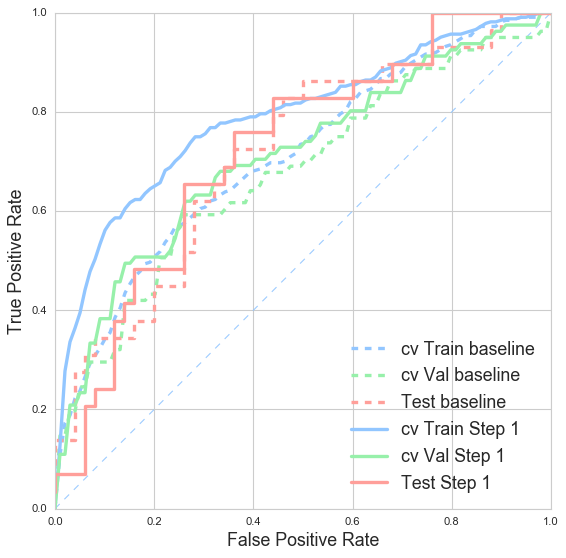

In [20]:
sns.set_style("whitegrid")
sns.set_color_codes("pastel")

figROCs = plt.figure(figsize=(8,8))    
axaroc = figROCs.add_subplot(1,1,1)
# add 50% or chance line
axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='b', alpha=.9)

# plot for train
mean_tpr_train = np.mean(tprs_train_baseL, axis=0)
mean_tpr_train[-1] = 1.0
mean_auc_train = auc(mean_fpr_OrigX, mean_tpr_train)
std_auc_train = np.std(auc_train_baseL)
axaroc.plot(mean_fpr_OrigX, mean_tpr_train, color='b', ls='--',
            label=r'cv Train baseline', lw=3, alpha=1)     
   
# plot for cv val
mean_tpr_val = np.mean(tprs_val_baseL, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_OrigX, mean_tpr_val)
std_auc_val = np.std(auc_val_baseL)
axaroc.plot(mean_fpr_OrigX, mean_tpr_val, color='g', ls='--',
            label=r'cv Val baseline', lw=3, alpha=1)     

# Compute ROC curve and area the curve for test
fpr_test, tpr_test, thresholds_test = roc_curve(y_val, probas_heldout_baseL.asnumpy()[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc.plot(fpr_test, tpr_test, color='r', ls='--',
            label=r'Test baseline', lw=3, alpha=1)     


# plot mean and 
mean_tpr_train = np.mean(tprs_train_step1, axis=0)
mean_tpr_train[-1] = 1.0
mean_auc_train = auc(mean_fpr_step1, mean_tpr_train)
std_auc_train = np.std(aucs_train_step1)
axaroc.plot(mean_fpr_step1, mean_tpr_train, color='b', 
            label=r'cv Train Step 1', lw=3, alpha=1)     

# plot for cv val
mean_tpr_val = np.mean(tprs_val_step1, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_step1, mean_tpr_val)
std_auc_val = np.std(aucs_val_step1)
axaroc.plot(mean_fpr_step1, mean_tpr_val, color='g',
            label=r'cv Val Step 1', lw=3, alpha=1)     

# plot AUC on heldout set
# plot for axaroc
# Compute ROC curve and area the curve
fpr_test, tpr_test, thresholds_test = roc_curve(yZ_test, probas_heldout_step1.asnumpy()[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc.plot(fpr_test, tpr_test, color='r',
            label=r'Test Step 1', lw=3, alpha=1)   
            
    
# set labels            
axaroc.set_xlabel('False Positive Rate',fontsize=16)
axaroc.set_ylabel('True Positive Rate',fontsize=16)
axaroc.legend(loc="lower right",fontsize=16)
plt.show()  

## Plot combined  b) baseline vs. Step2

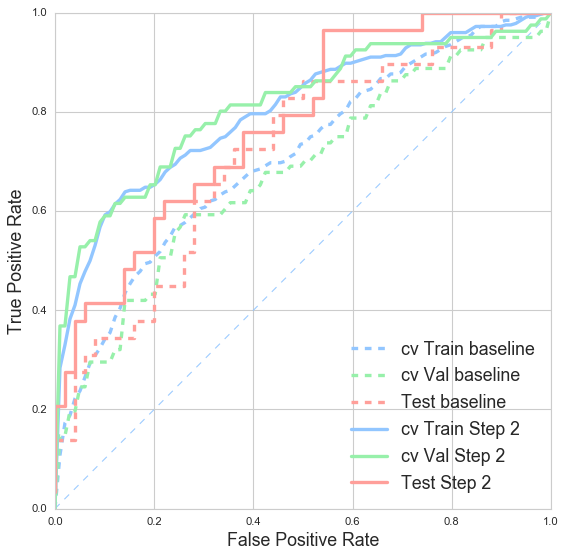

In [21]:
figROCs = plt.figure(figsize=(8,8))    
axaroc = figROCs.add_subplot(1,1,1)
# add 50% or chance line
axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='b', alpha=.9)

# plot for train
mean_tpr_train = np.mean(tprs_train_baseL, axis=0)
mean_tpr_train[-1] = 1.0
mean_auc_train = auc(mean_fpr_OrigX, mean_tpr_train)
std_auc_train = np.std(auc_train_baseL)
axaroc.plot(mean_fpr_OrigX, mean_tpr_train, color='b', ls='--',
            label=r'cv Train baseline', lw=3, alpha=1)     
   
# plot for cv val
mean_tpr_val = np.mean(tprs_val_baseL, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_OrigX, mean_tpr_val)
std_auc_val = np.std(auc_val_baseL)
axaroc.plot(mean_fpr_OrigX, mean_tpr_val, color='g', ls='--',
            label=r'cv Val baseline', lw=3, alpha=1)     

# Compute ROC curve and area the curve for test
fpr_test, tpr_test, thresholds_test = roc_curve(y_val, probas_heldout_baseL.asnumpy()[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc.plot(fpr_test, tpr_test, color='r', ls='--',
            label=r'Test baseline', lw=3, alpha=1) 
    
# plot for train
mean_tpr_train = np.mean(tprs_train_step2, axis=0)
mean_tpr_train[-1] = 1.0
mean_auc_train = auc(mean_fpr_step2, mean_tpr_train)
std_auc_train = np.std(aucs_train_step2)
axaroc.plot(mean_fpr_step2, mean_tpr_train, color='b', 
            label=r'cv Train Step 2', lw=3, alpha=1)     

# plot for cv val
mean_tpr_val = np.mean(tprs_val_step2, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_step2, mean_tpr_val)
std_auc_val = np.std(aucs_val_step2)
axaroc.plot(mean_fpr_step2, mean_tpr_val, color='g',
            label=r'cv Val Step 2', lw=3, alpha=1)     

# plot AUC on heldout set
# plot for axaroc
# Compute ROC curve and area the curve
fpr_test, tpr_test, thresholds_test = roc_curve(yZ_test, probas_heldout_step2.asnumpy()[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc.plot(fpr_test, tpr_test, color='r',
            label=r'Test Step 2', lw=3, alpha=1)   
            
    
# set labels            
axaroc.set_xlabel('False Positive Rate',fontsize=16)
axaroc.set_ylabel('True Positive Rate',fontsize=16)
axaroc.legend(loc="lower right",fontsize=16)
plt.show()    


## Plot with stds

In [ ]:
sns.set_style("whitegrid")
sns.set_color_codes("pastel")

figROCs = plt.figure(figsize=(8,8))    
axaroc = figROCs.add_subplot(1,1,1)
# add 50% or chance line
axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='b', alpha=.9)

# plot mean and 
mean_tpr_train = np.mean(tprs_train_step1, axis=0)
mean_tpr_train[-1] = 1.0
mean_auc_train = auc(mean_fpr_step1, mean_tpr_train)
std_auc_train = np.std(aucs_train_step1)
axaroc.plot(mean_fpr_step1, mean_tpr_train, color='b',
            label=r'cv Train Step 1 (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_train, std_auc_train),lw=3, alpha=1)     
std_tpr = np.std(tprs_train_step1, axis=0)
tprs_upper = np.minimum(mean_tpr_train + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_train - std_tpr, 0)
axaroc.fill_between(mean_fpr_step1, tprs_lower, tprs_upper, color='blue', alpha=.05, label=r'$\pm$ 1 std. dev.') 

# plot for cv val
mean_tpr_val = np.mean(tprs_val_step1, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_step1, mean_tpr_val)
std_auc_val = np.std(aucs_val_step1)
axaroc.plot(mean_fpr_step1, mean_tpr_val, color='g',
            label=r'cv Val Step 1 (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_val, std_auc_val),lw=3, alpha=1)     
std_tpr = np.std(tprs_val_step1, axis=0)
tprs_upper = np.minimum(mean_tpr_val + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_val - std_tpr, 0)
axaroc.fill_between(mean_fpr_step1, tprs_lower, tprs_upper, color='blue', alpha=.05, label=r'$\pm$ 1 std. dev.') 
    
    
# plot mean and 
mean_tpr_train = np.mean(tprs_train_step2, axis=0)
mean_tpr_train[-1] = 1.0
mean_auc_train = auc(mean_fpr_step2, mean_tpr_train)
std_auc_train = np.std(aucs_train_step2)
axaroc.plot(mean_fpr_step2, mean_tpr_train, color='b', ls='--',
            label=r'cv Train Step 2 (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_train, std_auc_train),lw=3, alpha=1)     
std_tpr = np.std(tprs_train_step2, axis=0)
tprs_upper = np.minimum(mean_tpr_train + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_train - std_tpr, 0)
axaroc.fill_between(mean_fpr_step2, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.') 

# plot for cv val
mean_tpr_val = np.mean(tprs_val_step2, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_step2, mean_tpr_val)
std_auc_val = np.std(aucs_val_step2)
axaroc.plot(mean_fpr_step2, mean_tpr_val, color='g', ls='--',
            label=r'cv Val Step 2 (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_val, std_auc_val),lw=3, alpha=1)     
std_tpr = np.std(tprs_val_step2, axis=0)
tprs_upper = np.minimum(mean_tpr_val + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_val - std_tpr, 0)
axaroc.fill_between(mean_fpr_step2, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.') 


# set labels            
axaroc.set_xlabel('False Positive Rate',fontsize=16)
axaroc.set_ylabel('True Positive Rate',fontsize=16)
axaroc.legend(loc="lower right",fontsize=16)
plt.show()    
